# Domain-Average Radiation Flux Budgets

We plot the domain-average radiation fluxes (and their components) and relative simulation to observation.

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import pylab as pl
import xarray as xr

import seaborn as sns

In [2]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3


In [3]:
import nawdex_analysis.io.collector

In [4]:
from  nawdex_analysis.plot.stacked_analysis_plots import hor_barplot_exp_plot


## Collect Data

In [5]:
rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict'  )
rset2= nawdex_analysis.io.collector.get_radflux4set( 2 )

rset

<xarray.Dataset>
Dimensions:        (ct: 11, idname: 16, time: 264)
Coordinates:
  * idname         (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct             (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
  * time           (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac          (time, ct, idname) float64 22.11 21.22 23.02 ... 8.958 8.958
    swf_up_clear   (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net_clear  (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_down       (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf_clear      (time, ct, idname) float64 276.2 276.4 275.8 ... 272.9 270.9
    swf_up         (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net        (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf            (time, ct, idname) float64 274.5 274.3 274.1 ... 255.8 255.8
    expname        (time, idname) object 'nawdexnwp-1

In [6]:
rset.sum('ct')

<xarray.Dataset>
Dimensions:        (idname: 16, time: 264)
Coordinates:
  * idname         (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * time           (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac          (time, idname) float64 100.0 100.0 100.0 ... 100.0 100.0
    swf_up_clear   (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swf_net_clear  (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swf_down       (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lwf_clear      (time, idname) float64 2.674e+03 2.669e+03 ... 2.655e+03
    swf_up         (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swf_net        (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lwf            (time, idname) float64 2.327e+03 2.31e+03 ... 2.165e+03

### Idname Set Selector

In [7]:
idset = 'old'
idset = 'all'

rset.idname.data


# old set 
if idset == 'old':
    rset = rset.sel( idname = ['10km_oneMom_Conv', '10km_twoMom_Conv', '20km_oneMom_Conv',
           '20km_twoMom_Conv', '2km_oneMom_noConv', '2km_twoMom_noConv', '40km_oneMom_Conv',
           '40km_twoMom_Conv', '5km_oneMom_Conv', '5km_twoMom_Conv',
           '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-not_scaled',
           'msevi-scaled'] )
elif idset == 'sh-only':
    rset = rset.sel( idname = ['10km_oneMom_Conv', '10km_twoMom_Conv', '20km_oneMom_Conv',
           '20km_twoMom_Conv', '2km_oneMom_shConv', '2km_twoMom_shConv', '40km_oneMom_Conv',
           '40km_twoMom_Conv', '5km_oneMom_Conv', '5km_twoMom_Conv',
           '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-not_scaled',
           'msevi-scaled'] )

else:
    pass

## Considerations for total domain-average radiation fluxes

In [8]:
def domaveflux(rset):
    idlist = list( rset.idname.data )
    idlist.remove( 'msevi-not_scaled')

    dset = xr.Dataset()
    dset['lwf'] = (rset['afrac'] * rset['lwf'] / 100.).sum('ct').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_net'] = (rset['afrac'] * rset['swf_net'] / 100.).sum('ct').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_up'] = (rset['afrac'] * rset['swf_up'] / 100.).sum('ct').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_down'] = (rset['afrac'] * rset['swf_down'] / 100.).sum('ct').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['fnet'] = dset['lwf'] + dset['swf_net']

    dset['ct'] = ['full']
    
    return dset

In [9]:
dset = domaveflux( rset )

In [10]:
dset.idname

<xarray.DataArray 'idname' (idname: 15)>
array(['10km_oneMom_Conv', '10km_twoMom_Conv', '20km_oneMom_Conv',
       '20km_twoMom_Conv', '2km_oneMom_noConv', '2km_oneMom_shConv',
       '2km_twoMom_noConv', '2km_twoMom_shConv', '40km_oneMom_Conv',
       '40km_twoMom_Conv', '5km_oneMom_Conv', '5km_twoMom_Conv',
       '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-scaled'], dtype=object)
Coordinates:
  * idname   (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'

## Plot fluxes for full set

In [11]:
from nawdex_analysis.plot.legend import legend_renamer, plegend

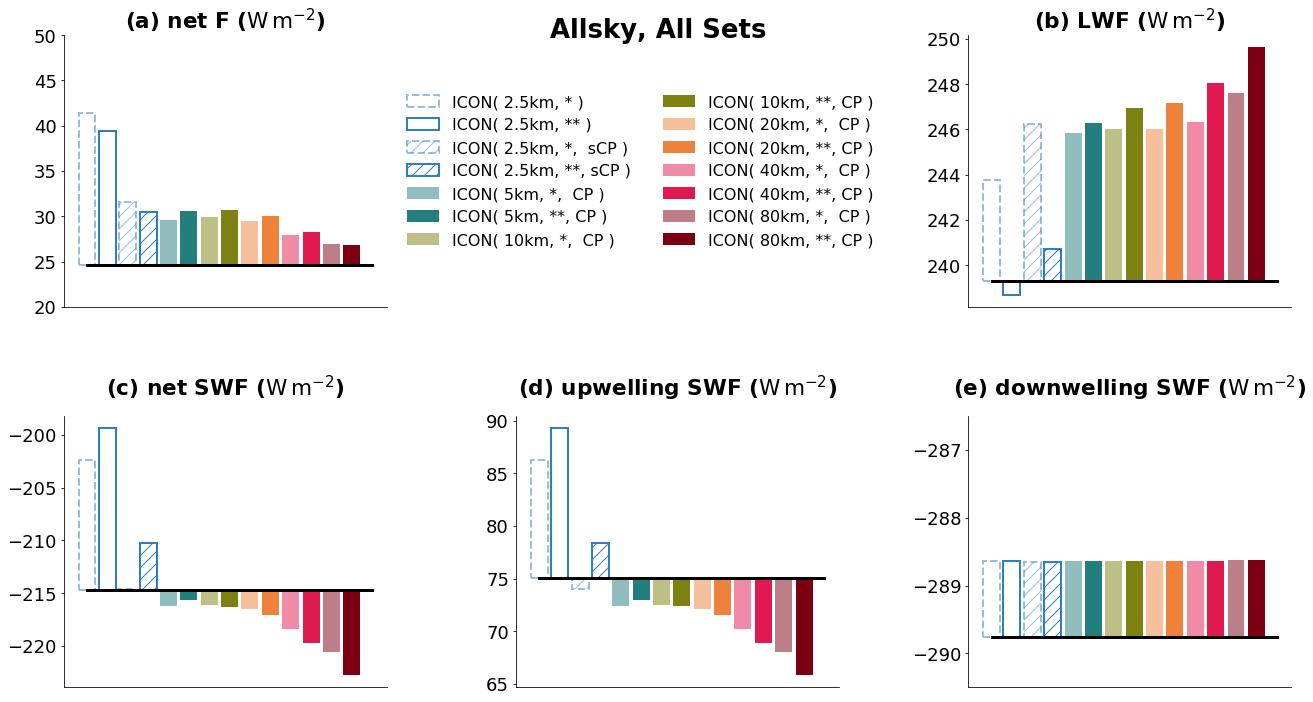

In [12]:
fig, ax = pl.subplots(ncols = 3, nrows = 2, figsize = (22,12))
ax = ax.flatten()




pl.sca(ax[0])
hor_barplot_exp_plot( dset, 'fnet', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(a) net F ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold')
pl.ylim(20,50)
#pl.legend(loc = 'center right', bbox_to_anchor = (2.3, 0.5), frameon = False)
plegend(loc = 'center right', bbox_to_anchor = (2.55, 0.5), frameon = False, ncol = 2, fontsize = 16)

a = ax[1]
a.axis('off')

pl.sca(ax[2])
hor_barplot_exp_plot( dset, 'lwf', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(b) LWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold')


pl.sca(ax[3])
hor_barplot_exp_plot( dset, 'swf_net', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(c) net SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)

pl.sca(ax[4])
hor_barplot_exp_plot( dset, 'swf_up', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(d) upwelling SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)
         
pl.sca(ax[5])
hor_barplot_exp_plot( dset, 'swf_down', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(e) downwelling SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)
pl.ylim(-290.5, -286.5)
pl.yticks([-287, -288, -289, -290])
sns.despine()
pl.subplots_adjust(wspace = 0.4, hspace = 0.4)
pl.suptitle('Allsky, All Sets', fontsize = 'x-large', fontweight = 'bold', y = 0.9)
pl.savefig('../pics/domain_average_radfluxes_allsets.png', dpi = 100)

## Plot fluxes only for set 2

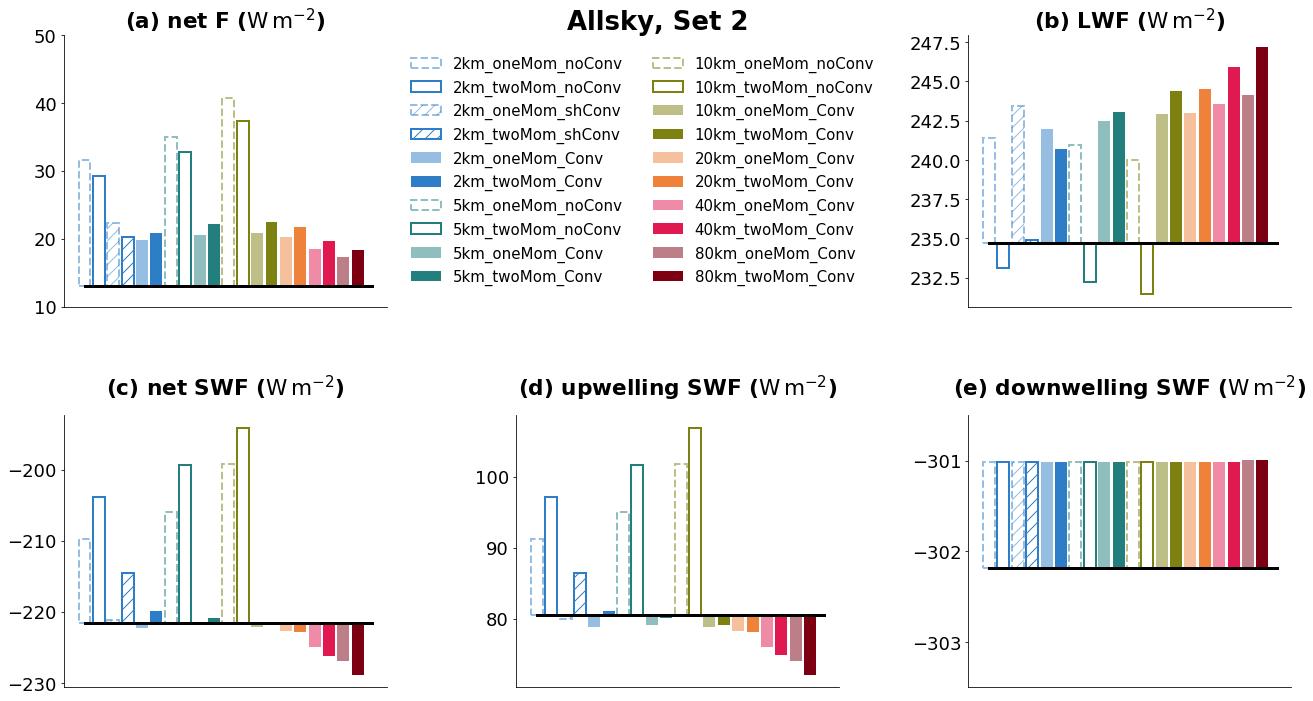

In [13]:
dset2 = domaveflux( rset2 )

fig, ax = pl.subplots(ncols = 3, nrows = 2, figsize = (22,12))
ax = ax.flatten()



pl.sca(ax[0])
hor_barplot_exp_plot( dset2, 'fnet', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(a) net F ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold')
pl.ylim(10,50)

pl.legend(loc = 'center right', bbox_to_anchor = (2.55, 0.5), frameon = False, ncol = 2, fontsize = 'small')

a = ax[1]
a.axis('off')

pl.sca(ax[2])
hor_barplot_exp_plot( dset2, 'lwf', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(b) LWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold')


pl.sca(ax[3])
hor_barplot_exp_plot( dset2, 'swf_net', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(c) net SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)

pl.sca(ax[4])
hor_barplot_exp_plot( dset2, 'swf_up', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(d) upwelling SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)
         
pl.sca(ax[5])
hor_barplot_exp_plot( dset2, 'swf_down', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(e) downwelling SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)

pl.ylim(-303.5, -300.5)
pl.yticks([-303, -302, -301])
sns.despine()
pl.subplots_adjust(wspace = 0.4, hspace = 0.4)
pl.suptitle('Allsky, Set 2', fontsize = 'x-large', fontweight = 'bold', y = 0.91)

pl.savefig('../pics/domain_average_radfluxes_set2.png', dpi = 100)

# Appendix

## Why do we have differences in the simulated downwelling SWF?

SOLVED: It was the order of summation `.sum('ct')` and temporal averaging `.mean('time')`....

NameError: name 'rset_inan' is not defined

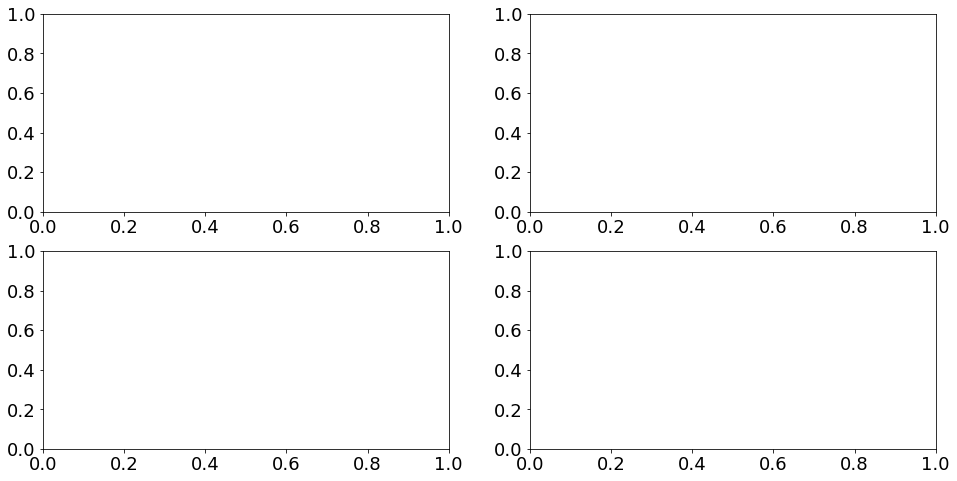

In [14]:
fig, axs = pl.subplots( ncols = 2, nrows = 2 )
axs = axs.flatten()

for i in range(4):
    pl.sca( axs[i] )

    rset1 = nawdex_analysis.io.collector.get_radflux4set( i + 1 )
    #rset_inan = rset1.interpolate_na()
    
    dset1 = domaveflux( rset_inan )

    hor_barplot_exp_plot( dset1, 'swf_down', catlist = ['full', ], icount0 = 0)
    pl.xticks([],[])
    pl.title('set %d' % (i + 1), fontweight = 'bold', pad = 20)
